In [47]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser

In [48]:
start_day_to_analyze = '2020-03-02'
end_day_to_analyze = '2020-03-03'

In [49]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [50]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [51]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [62]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [63]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [64]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty'] 
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [65]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [66]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,75,algo.py,PAPER,v0.1-135-g4ae45a8,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-03-02 14:45:30.513813,None,None


,symbol,count,revenue,%
1,VIVO,3,-110.05,-3.69
3,BGS,2,-64.28,-1.66
16,KRMD,1,-37.80,-2.29
6,OILU,1,-36.80,-1.14
15,SAVA,1,-30.16,-1.36
11,PAVM,1,-25.90,-1.78
5,LADR,1,-24.80,-1.24
10,OMI,1,-15.92,-1.11
0,PRQR,3,-12.92,-1.77
4,RMTI,1,0.00,0.00


TOTAL REVENUE: -133.43 $


In [67]:
minute_history = {}

for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

In [68]:
high_15m = {}

lbound = datetime.strptime(start_day_to_analyze, '%Y-%m-%d') + timedelta(minutes=9*60+30)
ubound = lbound + timedelta(minutes=15)

for symbol, count in symbols.items():
    try:
        high_15m[symbol] = minute_history[symbol][pd.Timestamp(str(lbound)):pd.Timestamp(str(ubound))]["high"].max()
    except:
        print(symbol)

PGP


In [69]:
bbands = {}

for symbol, count in symbols.items():
    upperband, middleband, lowerband = BBANDS(minute_history[symbol]["close"].dropna().between_time("9:30", "16:00"),
                                              timeperiod=20)
    bbands[symbol] = upperband
    
                                              

nan
nan
nan
nan
all


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
0,PRQR,75,False,6.644737,False,0.05,0.04
17,PAVM,75,False,0.704626,False,0.02,0.01
16,OMI,75,False,0.276625,False,NaN,NaN
12,OILU,75,False,0.683010,False,0.03,0.02
21,SAVA,75,False,1.497453,False,NaN,NaN
9,BGS,75,False,0.830671,True,0.03,0.03
8,BGS,75,False,0.701978,True,0.03,0.03
11,LADR,75,False,0.185759,False,NaN,NaN
6,GNPX,75,False,4.666667,False,0.03,0.02
5,VIVO,75,False,1.376147,False,0.04,0.03


winners analysis


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
0,PRQR,75,False,6.644737,False,0.05,0.04
17,PAVM,75,False,0.704626,False,0.02,0.01
16,OMI,75,False,0.276625,False,NaN,NaN
12,OILU,75,False,0.683010,False,0.03,0.02
11,LADR,75,False,0.185759,False,NaN,NaN
9,BGS,75,False,0.830671,True,0.03,0.03
8,BGS,75,False,0.701978,True,0.03,0.03
21,SAVA,75,False,1.497453,False,NaN,NaN
6,GNPX,75,False,4.666667,False,0.03,0.02
5,VIVO,75,False,1.376147,False,0.04,0.03


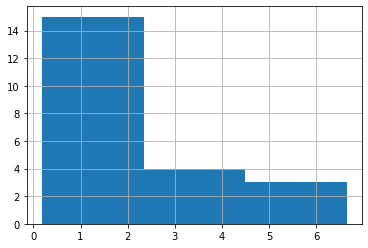

In [70]:
slopes = []
win = []
macd = []
macd_signal = []
bail_outs = []
symbols = []
r_ids = []
scalp = []

for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(f'1 {symbol}')
            continue
        for trade in trade_details[run_id][symbol]:
            if math.isnan(trade[3]):
                print(f'2 {symbol}')
                continue 
                
            min_time = trade_details[run_id][symbol][0][0]
            max_time = trade_details[run_id][symbol][-1][2]
            
            if min_time is None or max_time is None:
                print(f'3 {symbol}')
                continue
             
            try:
                max_val = minute_history[symbol]['close'][min_time:max_time].max()
            except Exception:
                print(f'4 {symbol}')
                continue
                
            if math.isnan(max_val):
                print(f'5 {symbol}')
                continue
            max_val_index = minute_history[symbol]['close'][min_time:max_time].idxmax()
            
            macds = MACD(
                minute_history[symbol]["close"][:max_val_index]
                .dropna()
                .between_time("9:30", "16:00"),
                13,
                21,
            )
            
            macd_val = macds[0][-1].round(2)
            
            if math.isnan(macd_val):
                print(macds[0][-5])
            macd.append(macd_val)
            macd_signal_val = macds[1][-1].round(2)
            macd_signal.append(macd_signal_val)
            
            bail_out = ((max_val - trade[1]) / trade[1] > 0.003 and macd_val == macd_signal_val)
            bail_outs.append(bail_out)
            #if bail_out == True:
            #     print('bailout!!!')
            
            slope = 100.0 * (max_val - trade[1]) / trade[1]
            slopes.append(slope)
            win.append(trade[3] >= trade[1])
            symbols.append(symbol)
            r_ids.append(run_id)
            #plt.scatter(slope, int(trade[3] >= trade[1]), c=('g' if win else 'r'), s=10)
            
#plt.show()           


d = {
    'symobl':symbols,
    'run': r_ids,
    'win': win,
    'max_val %': slopes,
    'bail_outs': bail_outs,
    'macd': macd,
    'macd_signal': macd_signal,
}
slope_analysis = pd.DataFrame(data=d)
print("all")
display(HTML(slope_analysis.sort_values(by=['win']).to_html()))
print("winners analysis")
display(HTML(slope_analysis.loc[slope_analysis['max_val %'] > 0].sort_values(by=['win']).to_html()))
slope_analysis.loc[slope_analysis['max_val %'] > 0.003]['max_val %'].hist(bins=3)


PRQR analysis for run 75
buy-price 7.6 sell-price 7.45
buy-price 7.7 sell-price 7.54
buy-price 7.89 sell-price 8.07


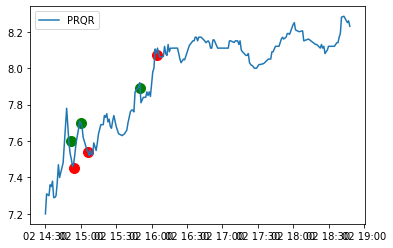

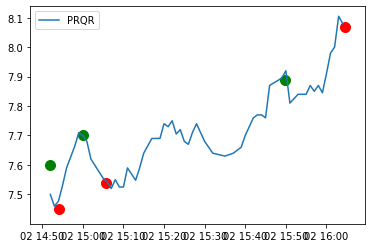

Delta = -0.129999999999999


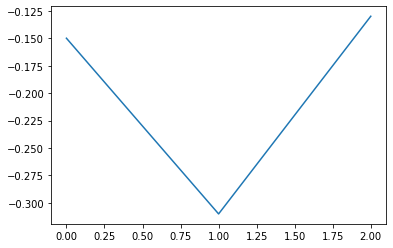

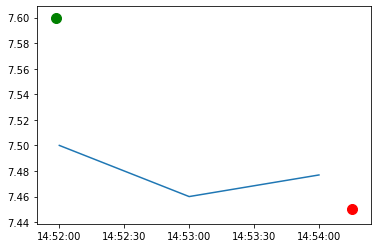

buy time:2020-03-02T14:51:58.488457817Z sell time:2020-03-02T14:54:15.165366045Z
{'rsi': 67.10784112127118, 'macd1': [0.11041233746667523, 0.11573259598305974, 0.1425136236413893, 0.14631626783362517, 0.14922356721120522], 'macd2': [0.04363989065773133, 0.04762635833283202, 0.056015945172926074, 0.06052629124984055, 0.06489902262048464], 'sell_macd': [0.06841114443119434, 0.07150218885051807, 0.08856661062076387, 0.09058347679730883, 0.09201761308036627], 'macd_signal': [0.09427754943107666, 0.09856855874147327, 0.10735757172145648, 0.11514931094389022, 0.12196416219735322], 'sell_macd_signal': [0.05933857033705324, 0.061771294039746204, 0.06713035735594974, 0.07182098124422157, 0.0758603076114505]}
{'rsi': 59.269226561670685, 'macd': [0.09058347679730883, 0.08812150918426198, 0.08350021611975489, 0.07673686806793434, 0.07176884532537375], 'scalp': 0, 'bail_out': 0, 'movement': -0.01577909270216964, 'too_close': 1, 'macd_signal': [0.07182098124422157, 0.07508108683222965, 0.07676491268

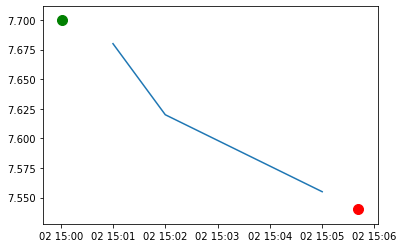

buy time:2020-03-02T15:00:01.062592443Z sell time:2020-03-02T15:05:41.298049407Z
{'rsi': 68.91099030317993, 'macd1': [0.11924282777493733, 0.11603152529462246, 0.11697957576965035, 0.12221261160313812, 0.12863721105554937], 'macd2': [0.06889822842989357, 0.07097639827436719, 0.07373448032915952, 0.07732160903238317, 0.08124351895241055], 'sell_macd': [0.0713480661045951, 0.06898084293699736, 0.069357281469558, 0.07254207407324742, 0.07650240501023653], 'macd_signal': [0.12351486182347196, 0.12201819451770206, 0.12101047076809171, 0.12125089893510099, 0.12272816135919067], 'sell_macd_signal': [0.07567705623321871, 0.07433781357397444, 0.07334170715309116, 0.0731817805371224, 0.07384590543174523]}
{'rsi': 55.72012969421438, 'macd': [0.07650240501023653, 0.07809613814282113, 0.07728481151700706, 0.07253202698368444, 0.0642502205033848], 'scalp': 0, 'bail_out': 0, 'movement': -0.02070146311092666, 'too_close': 1, 'macd_signal': [0.07384590543174523, 0.07469595197396041, 0.07521372388256974

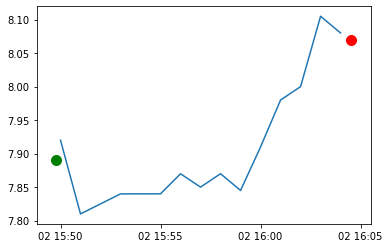

buy time:2020-03-02T15:49:47.678231952Z sell time:2020-03-02T16:04:32.444903807Z
{'rsi': 73.213211841235, 'macd1': [0.03672348050523677, 0.03925722350395855, 0.039997253220860784, 0.04889616820452147, 0.05730533329765031], 'macd2': [0.07801028035902746, 0.07791949077840243, 0.07755140409782157, 0.07884801622560822, 0.08031467453873642], 'sell_macd': [0.019419878628776033, 0.021198327138115758, 0.02178934770204144, 0.02768119037910033, 0.03321144194071657], 'macd_signal': [0.03596968534523741, 0.03662719297698164, 0.03730120502575747, 0.03962019766151027, 0.04315722478873828], 'sell_macd_signal': [0.01827335557279572, 0.018858349885859726, 0.019444549449096068, 0.02109187763509692, 0.02351579049622085]}
{'rsi': 78.9774724909493, 'macd': [0.03292027523285057, 0.03723082619776097, 0.041145140895122445, 0.04911544921910416, 0.05806483948169827], 'scalp': 1, 'bail_out': 0, 'movement': 0.034832172260924686, 'too_close': 0, 'macd_signal': [0.03234798378225913, 0.0333245522653595, 0.0348886699

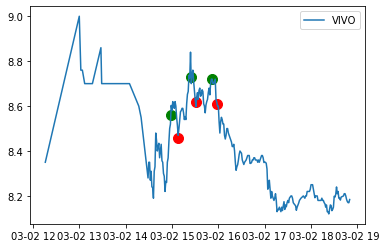

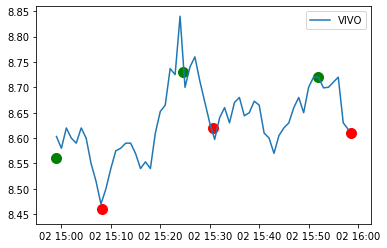

Delta = -0.32000000000000206


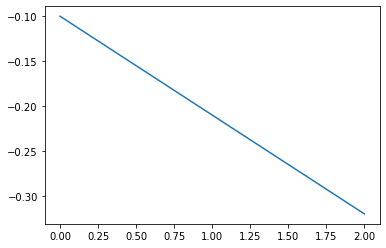

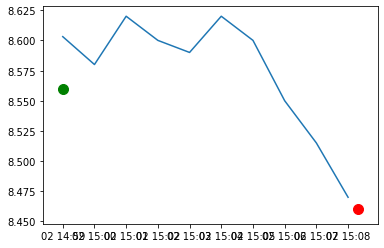

buy time:2020-03-02T14:58:59.951858326Z sell time:2020-03-02T15:08:18.106855179Z
{'rsi': 62.64519895234092, 'macd1': [0.03012623084345556, 0.03238689452882859, 0.039452806025588316, 0.049317519522757536, 0.06127856263851328], 'macd2': [0.043089041957790286, 0.04371139007575131, 0.04534960577312397, 0.047742303052835666, 0.050828519457637], 'sell_macd': [0.01504921719148733, 0.01661276188582761, 0.021303669934848557, 0.02779394023363224, 0.035612411372508035], 'macd_signal': [0.05138588200199555, 0.04758608450736216, 0.04595942881100739, 0.046631046953357416, 0.04956055009038859], 'sell_macd_signal': [0.029220880560766566, 0.026699256825778776, 0.025620139447592734, 0.026054899604800636, 0.027966401958342116]}
{'rsi': 49.28304301322721, 'macd': [0.05606922332171571, 0.05532147580468383, 0.05142295207966363, 0.04589912902017268, 0.038687070415111435], 'scalp': 0, 'bail_out': 0, 'movement': -0.010455607476635632, 'too_close': 1, 'macd_signal': [0.04600729501780273, 0.04787013117517895, 0.

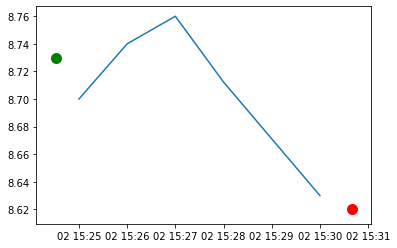

buy time:2020-03-02T15:24:30.969473414Z sell time:2020-03-02T15:30:39.446800272Z
{'rsi': 70.28909220093016, 'macd1': [0.04599376212258122, 0.04979802588758808, 0.05794668808652581, 0.06272131872003328, 0.0685393761255444], 'macd2': [0.06717668660088094, 0.0680042007298205, 0.0698067170064185, 0.07116311967911848, 0.07285701414979684], 'sell_macd': [0.025105383238118506, 0.027662353045931454, 0.03303061064882584, 0.03616651773356416, 0.03995856847837764], 'macd_signal': [0.04943418270294811, 0.04950695133987611, 0.05119489868920605, 0.0535001826953715, 0.05650802138140608], 'sell_macd_signal': [0.02711214736306459, 0.02722218849963796, 0.028383872929475536, 0.02994040189029326, 0.031944035207910136]}
{'rsi': 50.74227214926172, 'macd': [0.04246193576935475, 0.042700759825700985, 0.0433712622095328, 0.04085254637603164, 0.03434377369569219], 'scalp': 0, 'bail_out': 0, 'movement': -0.014269406392694065, 'too_close': 1, 'macd_signal': [0.03471255038513421, 0.03631019227324757, 0.03772240626

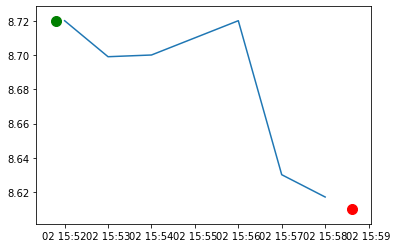

buy time:2020-03-02T15:51:48.015038699Z sell time:2020-03-02T15:58:36.480516661Z
{'rsi': 59.316727353028064, 'macd1': [0.002854389208213348, 0.00637178437369279, 0.006661802986261733, 0.010801711551820858, 0.015517574826240832], 'macd2': [0.05192301796172849, 0.05143346948749006, 0.050421000508213965, 0.05020853544490045, 0.050252631305570006], 'sell_macd': [-0.0008173817130590066, 0.001647964756074316, 0.001989170254672601, 0.004826613886637077, 0.008013886666262238], 'macd_signal': [0.009190410302836485, 0.008626685117007746, 0.008233708690858543, 0.008747309263051006, 0.010101362375688972], 'sell_macd_signal': [0.0026237787296678346, 0.002428615934949131, 0.002340726798893825, 0.002837904216442475, 0.0038731007064064273]}
{'rsi': 44.740644409387784, 'macd': [0.011021676853786744, 0.01142005309631422, 0.01262112480352684, 0.008728179058451246, 0.004906037191398482], 'scalp': 0, 'bail_out': 0, 'movement': -0.011788990825688099, 'too_close': 1, 'macd_signal': [0.006346063726054238, 0.0

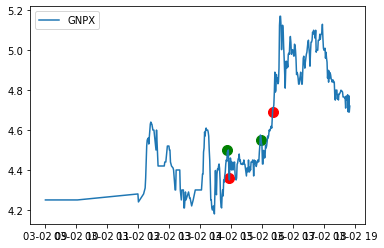

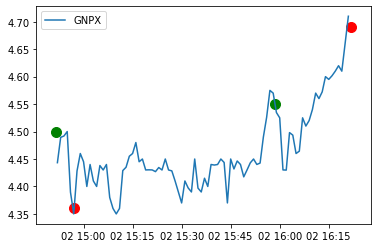

Delta = 8.881784197001252e-16


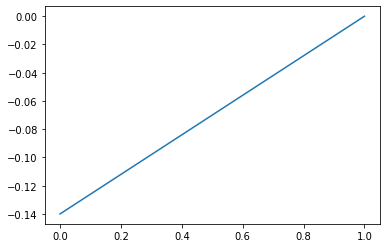

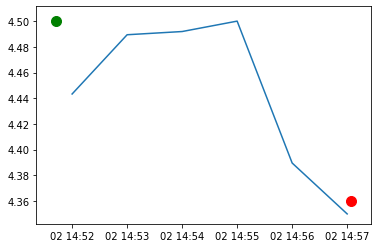

buy time:2020-03-02T14:51:42.49618503Z sell time:2020-03-02T14:57:04.237109845Z
{'rsi': 63.29902076491096, 'macd1': [0.04267526864571991, 0.045002265312189316, 0.04790800611569512, 0.052829506675528215, 0.06166738310644515], 'macd2': [0.03338713906565882, 0.03465783453872007, 0.03609135670799546, 0.037992263978955165, 0.04079994833503786], 'sell_macd': [0.02439971647742034, 0.025878624878482803, 0.027733896036733263, 0.030897303484244354, 0.03659739625523617], 'macd_signal': [0.050749973525641194, 0.04960043188295082, 0.04926194672949968, 0.04997545871870539, 0.05231384359625334], 'sell_macd_signal': [0.03021457291464366, 0.02934738330741149, 0.029024685853275844, 0.029399209379469545, 0.03083884675462287]}
{'rsi': 53.969581634298756, 'macd': [0.03882879331500444, 0.04094846818857878, 0.0424891438278765, 0.037402798302291984, 0.034953661551157644], 'scalp': 0, 'bail_out': 0, 'movement': -0.015977777777777844, 'too_close': 1, 'macd_signal': [0.032870643294345275, 0.03448620827319197, 0.

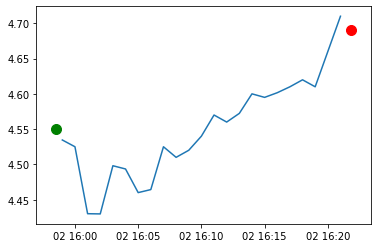

buy time:2020-03-02T15:58:31.14300287Z sell time:2020-03-02T16:21:51.352515642Z
{'rsi': 69.43928943383071, 'macd1': [0.006509852690407492, 0.0066608503497667115, 0.010476465605962382, 0.016218312708611293, 0.02397824063566034], 'macd2': [0.01983707415357383, 0.019553890861283563, 0.020018576859282433, 0.020989855617362885, 0.022540816432986333], 'sell_macd': [0.003795575671754925, 0.0038937300823702614, 0.00637678897268934, 0.010098954484980993, 0.015112343786961802], 'macd_signal': [0.005217026047193086, 0.005505790907707811, 0.006499925847358725, 0.008443603219609238, 0.011550530702819459], 'sell_macd_signal': [0.0028890669436086687, 0.003089999571360987, 0.0037473574516266577, 0.005017676858297525, 0.00703661024403038]}
{'rsi': 74.8676055964209, 'macd': [0.022518149100039686, 0.023555924904033354, 0.023544374557742387, 0.025827005787155244, 0.02986766641024108], 'scalp': 1, 'bail_out': 0, 'movement': 0.03083758289378658, 'too_close': 0, 'macd_signal': [0.017586009371077287, 0.018779

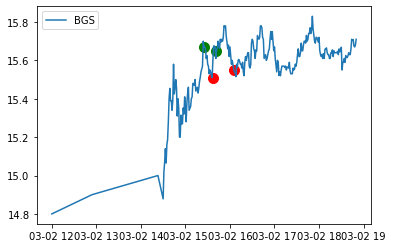

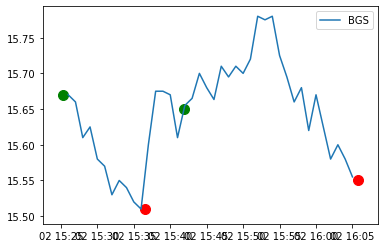

Delta = -0.2599999999999998


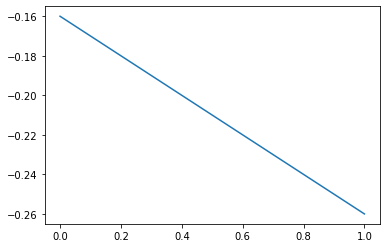

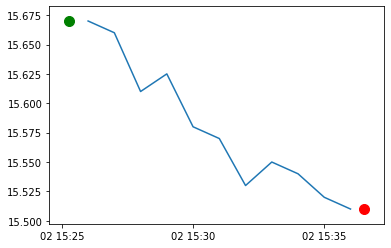

buy time:2020-03-02T15:25:16.006493254Z sell time:2020-03-02T15:36:31.315885724Z
{'rsi': 70.06350411670958, 'macd1': [0.041447803728623, 0.04503087935778893, 0.04852154112585083, 0.05190001925039134, 0.061932729812347986], 'macd2': [0.04763861733217212, 0.048722398723292315, 0.049881491640555, 0.05110801976373125, 0.053754084990588424], 'sell_macd': [0.023623780886502743, 0.025966240587626643, 0.028233530736715196, 0.03041280188228157, 0.03691076898425116], 'macd_signal': [0.04051106158828787, 0.04141502514218808, 0.042836328338920635, 0.044649066521214774, 0.04810579917944142], 'sell_macd_signal': [0.02292159270496472, 0.023530522281497105, 0.024471123972540722, 0.02565945955448889, 0.027909721440441345]}
{'rsi': 47.926141561129135, 'macd': [0.02805499065972228, 0.02416988538626086, 0.020309155492833852, 0.01599807823181365, 0.011911549479956207], 'scalp': 0, 'bail_out': 0, 'movement': -0.010210593490746659, 'too_close': 1, 'macd_signal': [0.03582051122280671, 0.03349038605549754, 0.0

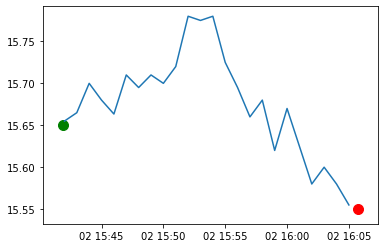

buy time:2020-03-02T15:41:52.247995345Z sell time:2020-03-02T16:05:43.064940953Z
{'rsi': 63.92880222763734, 'macd1': [0.02652288968849348, 0.033684370331158675, 0.03891134952035635, 0.04216426655439598, 0.04503006461178316], 'macd2': [0.05508064640761212, 0.05618188963507542, 0.0571052135486525, 0.057783401261945144, 0.05847487520166439], 'sell_macd': [0.01324787058915966, 0.01801321339387485, 0.02149252969113391, 0.023664821225477084, 0.025569661106453978], 'macd_signal': [0.0406611540277161, 0.03926579728840461, 0.03919490773479496, 0.03978877949871516, 0.040837036521328765], 'sell_macd_signal': [0.022400495699095052, 0.02152303923805101, 0.02151693732866759, 0.02194651410802949, 0.022671143507714386]}
{'rsi': 36.32834177785477, 'macd': [0.00563934282724432, -2.1244797743236177e-05, -0.003392855352307933, -0.007014982338303, -0.012863198400918208], 'scalp': 0, 'bail_out': 0, 'movement': -0.01020408163265307, 'too_close': 1, 'macd_signal': [0.01694248263800739, 0.013549737150857263, 0

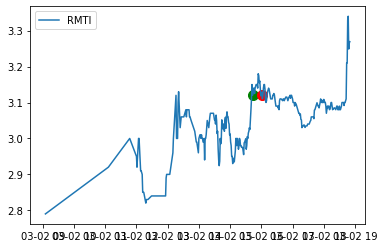

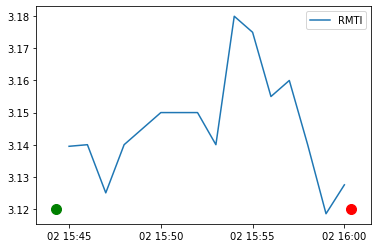

Delta = 0.0


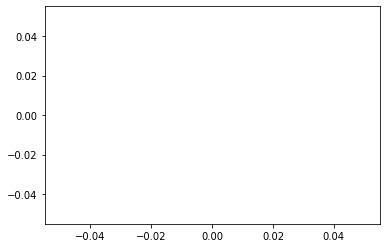

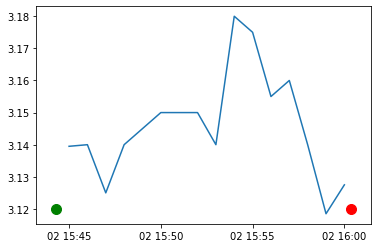

buy time:2020-03-02T15:44:17.9302593Z sell time:2020-03-02T16:00:22.402007956Z
{'rsi': 69.77751969600739, 'macd1': [0.017521240056072696, 0.023115110446533915, 0.030552870889811956, 0.03363883282241087, 0.03567326074313737], 'macd2': [0.02135654075303206, 0.022497567972609822, 0.024176701663276567, 0.025203083036955842, 0.026107077922476574], 'sell_macd': [0.011104100803858596, 0.014689662614113086, 0.019453871003737966, 0.021355151943657447, 0.022559329923546922], 'macd_signal': [0.008944866562148492, 0.011778915339025576, 0.015533706449182852, 0.019154731723828457, 0.02245843752769024], 'sell_macd_signal': [0.005545205673560141, 0.00737409706167073, 0.009790051850084178, 0.012103071868798831, 0.01419432347974845]}
{'rsi': 57.003103930797415, 'macd': [0.022454138092887543, 0.021388963099372216, 0.019242216830407166, 0.016202645493156087, 0.014740607496685598], 'scalp': 0, 'bail_out': 1, 'movement': 0.006410256410256416, 'too_close': 1, 'macd_signal': [0.02316542154892388, 0.0228101298

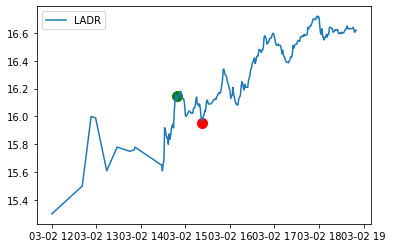

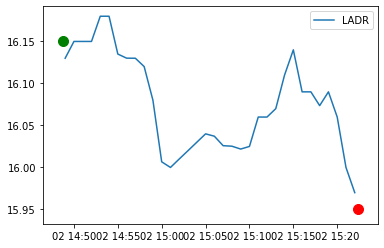

Delta = -0.1999999999999993


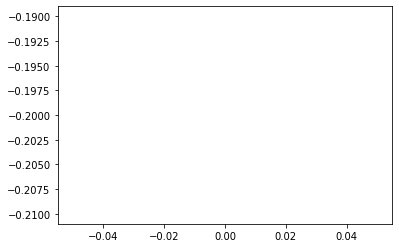

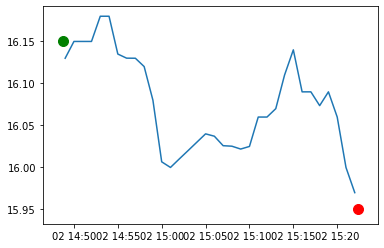

buy time:2020-03-02T14:48:44.6874185Z sell time:2020-03-02T15:22:19.8051068Z
{'rsi': 70.57936699954422, 'macd1': [0.1539012481250701, 0.15846878698867073, 0.1658254765599967, 0.17344880341434, 0.17728532669435992], 'macd2': [0.07539968860844759, 0.08012129228978004, 0.08545672807609961, 0.09098052289098035, 0.09588509297393699], 'sell_macd': [0.09332428304089468, 0.09587510369756558, 0.10025398857682255, 0.10480566525446555, 0.10688741766231225], 'macd_signal': [0.14961902846785935, 0.15138898017202163, 0.15427627944961664, 0.1581107842425613, 0.16194569273292103], 'sell_macd_signal': [0.09262859554651216, 0.09327789717672284, 0.09467311545674278, 0.09669962541628734, 0.09873718386549232]}
{'rsi': 36.76840931837268, 'macd': [0.013975313237260423, 0.013529252587595408, 0.011447526723085133, 0.006559850377708898, 6.86759478369936e-05], 'scalp': 0, 'bail_out': 0, 'movement': -0.012689569792633974, 'too_close': 1, 'macd_signal': [0.015768539457905958, 0.015320682083843847, 0.01454605101169

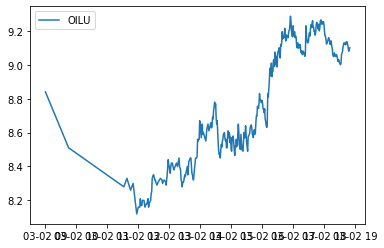

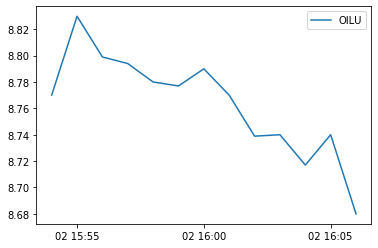

Delta = 0


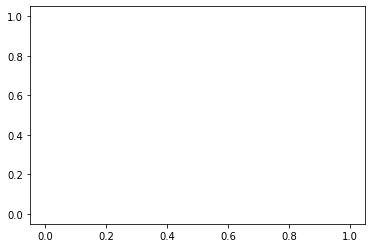

ONCY analysis for run 75
buy-price 2.36 sell-price 2.38


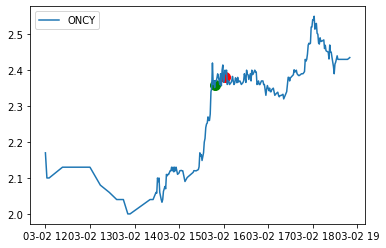

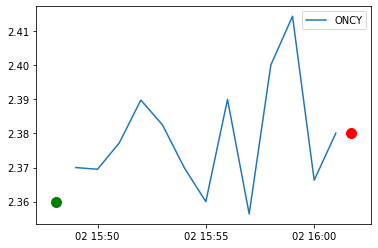

Delta = 0.020000000000000018


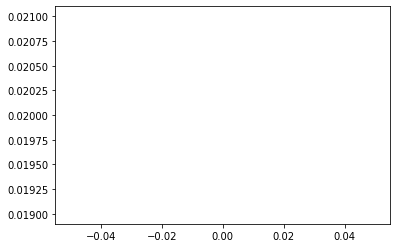

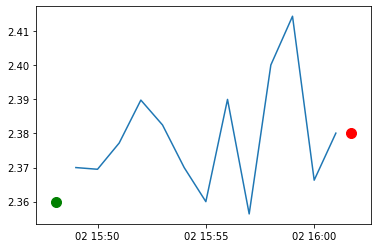

buy time:2020-03-02T15:48:04.862503758Z sell time:2020-03-02T16:01:42.964268009Z
{'rsi': 73.93232224202816, 'macd1': [0.04698455064729323, 0.051649923605106896, 0.060300572804475205, 0.061604636162333914, 0.06348782385111429], 'macd2': [0.03128710324178474, 0.03312065067850645, 0.03587415329713162, 0.03739047193458456, 0.0390392073592305], 'sell_macd': [0.02879814184207774, 0.03171690740074995, 0.03721572592178379, 0.03790031534178695, 0.03895973157371424], 'macd_signal': [0.03624502599457733, 0.03932600551668324, 0.04352091897424164, 0.04713766241186009, 0.05040769469971093], 'sell_macd_signal': [0.022091398090612946, 0.024016499952640345, 0.026656345146469036, 0.02890513918553262, 0.030916057663168944]}
{'rsi': 60.14296772404535, 'macd': [0.026421621954425767, 0.02624176564357672, 0.026503672860531236, 0.023864851563865308, 0.02272986287082901], 'scalp': 0, 'bail_out': 1, 'movement': 0.004370482434022604, 'too_close': 1, 'macd_signal': [0.03116273369566468, 0.030178540085247087, 0.02

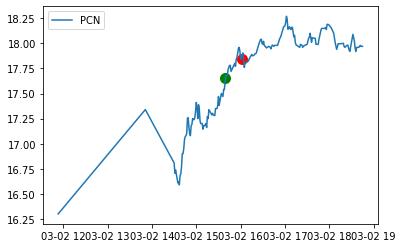

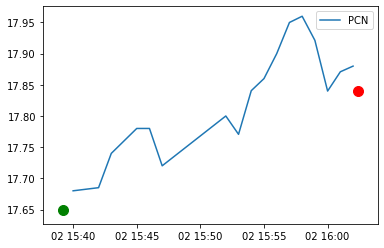

Delta = 0.19000000000000128


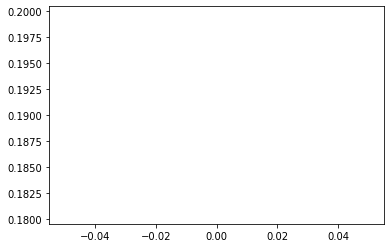

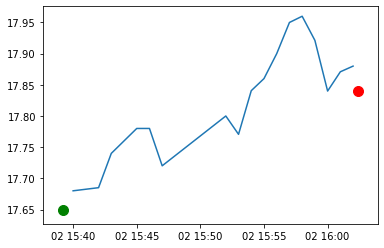

buy time:2020-03-02T15:39:11.229495806Z sell time:2020-03-02T16:02:21.814709731Z
{'rsi': 71.93570556043036, 'macd1': [0.07571260996087759, 0.07784320224303798, 0.08420143605677666, 0.08823137495863165, 0.09915817751753409], 'macd2': [0.11341759545543084, 0.11374990808909402, 0.11499167207857752, 0.11595182091963707, 0.11840903611339826], 'sell_macd': [0.043085218571800254, 0.044533733776997764, 0.04871525557615186, 0.05134611339917683, 0.05844358555479445], 'macd_signal': [0.06399372922902426, 0.066763623831827, 0.07025118627681694, 0.07384722401317988, 0.07890941471405072], 'sell_macd_signal': [0.034701505015151415, 0.036667950767520684, 0.03907741172924692, 0.0415311520632329, 0.04491363876154521]}
{'rsi': 62.02400116029262, 'macd': [0.09094369473806907, 0.08906215848138999, 0.08221599830110193, 0.07741878259826507, 0.07107005889997708], 'scalp': 0, 'bail_out': 1, 'movement': 0.010764872521246532, 'too_close': 1, 'macd_signal': [0.08301506153532275, 0.08422448092453619, 0.08382278439

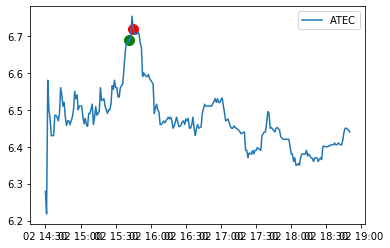

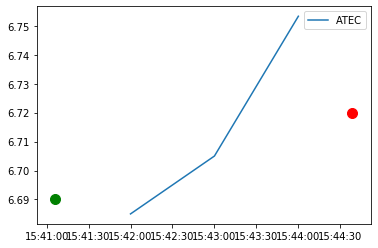

Delta = 0.02999999999999936


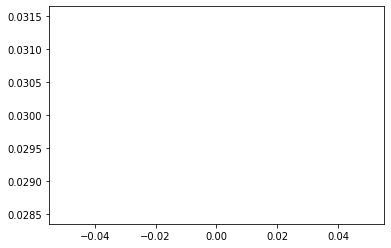

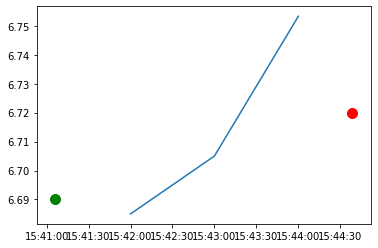

buy time:2020-03-02T15:41:05.693451018Z sell time:2020-03-02T15:44:38.424507551Z
{'rsi': 74.57174894764795, 'macd1': [0.02434579675027848, 0.0301553329295432, 0.03675647571466989, 0.04150943401396123, 0.04555794055598206], 'macd2': [0.06179218564529254, 0.06221767521397936, 0.06298943882721009, 0.06359874323294257, 0.06421754149949876], 'sell_macd': [0.013527775409292175, 0.01735464918740881, 0.02166968525883206, 0.024750626544891574, 0.027349403825653873], 'macd_signal': [0.021769471502017447, 0.0234466437875226, 0.026108610172952056, 0.02918877494115389, 0.032462608064119526], 'sell_macd_signal': [0.011482912613191235, 0.01265725992803475, 0.014459744994194213, 0.016517921304333685, 0.018684217808597723]}
{'rsi': 78.35467465964348, 'macd': [0.024750626544891574, 0.027349403825653873, 0.02875949776097997, 0.03052373332407754, 0.033320232031373465], 'scalp': 0, 'bail_out': 0, 'movement': 0.007473841554559016, 'too_close': 0, 'macd_signal': [0.016517921304333685, 0.018684217808597723, 0

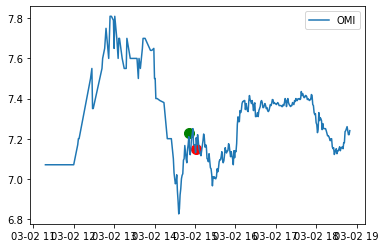

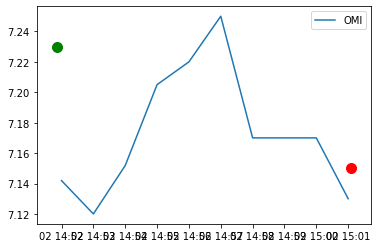

Delta = -0.08000000000000007


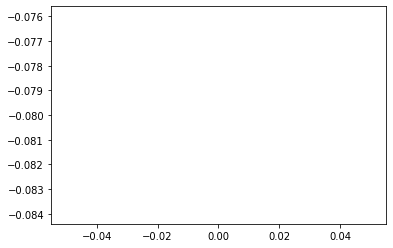

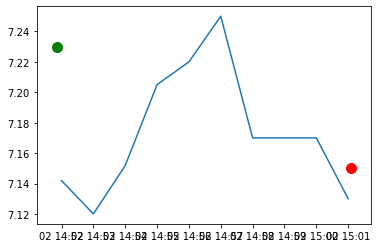

buy time:2020-03-02T14:51:50.565985229Z sell time:2020-03-02T15:01:05.870715154Z
{'rsi': 58.51481338312365, 'macd1': [0.09248963163494839, 0.08872861614823702, 0.08995598445752861, 0.09188676037554888, 0.09713865876857852], 'macd2': [0.053116959045749645, 0.0544224848541317, 0.056576153364995996, 0.05886695169767808, 0.061840026130589365], 'sell_macd': [0.05605141698054794, 0.05338396253659905, 0.05398875176811124, 0.055057564782691415, 0.058292255900770584], 'macd_signal': [0.08025006917185011, 0.0819457785671275, 0.08354781974520772, 0.08521560787127595, 0.08760021805073646], 'sell_macd_signal': [0.04888856585806779, 0.049787645193774044, 0.050627866508641484, 0.05151380616345147, 0.05286949611091529]}
{'rsi': 49.94277414966038, 'macd': [0.051325204492909116, 0.04756221745464462, 0.04401232862671556, 0.04067459280460639, 0.036766297452254015], 'scalp': 0, 'bail_out': 0, 'movement': -0.010373443983402513, 'too_close': 1, 'macd_signal': [0.051133608054789226, 0.0504193299347603, 0.0491

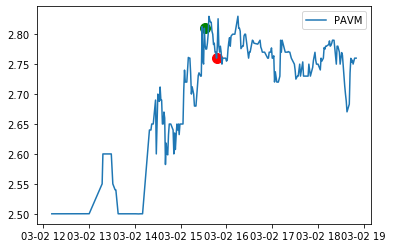

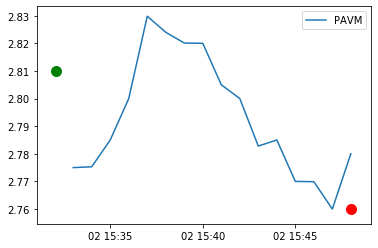

Delta = -0.050000000000000266


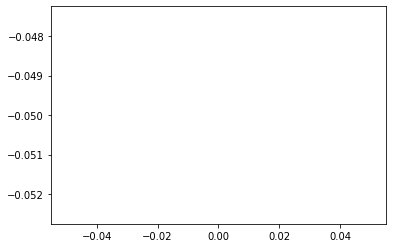

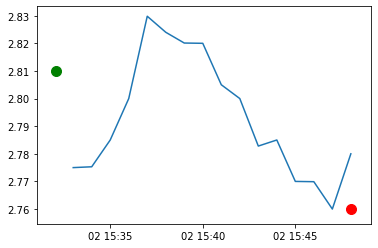

buy time:2020-03-02T15:32:05.335142058Z sell time:2020-03-02T15:48:01.281378266Z
{'rsi': 64.37125325951865, 'macd1': [0.022544278249434502, 0.02284805992128236, 0.02237896510667614, 0.02653475731623889, 0.02948832947682245], 'macd2': [0.03293869268719263, 0.032984068389906085, 0.03288349790545331, 0.033696394076445646, 0.03439039188258208], 'sell_macd': [0.01282944353663451, 0.013040692191758296, 0.012745032803650247, 0.01546081727001214, 0.017376223123410917], 'macd_signal': [0.019310023825625838, 0.020017631044757143, 0.02048989785714094, 0.02169886974896053, 0.023256761694532915], 'sell_macd_signal': [0.01060956920377358, 0.011095793801370523, 0.011425641601826467, 0.012232676735463601, 0.013261386013053064]}
{'rsi': 49.47772471515206, 'macd': [0.012570708086788063, 0.01027255800268545, 0.008343187053998946, 0.006217142327048286, 0.004853767964138278], 'scalp': 0, 'bail_out': 0, 'movement': -0.015231316725978708, 'too_close': 0, 'macd_signal': [0.015677024889995544, 0.01459613151253

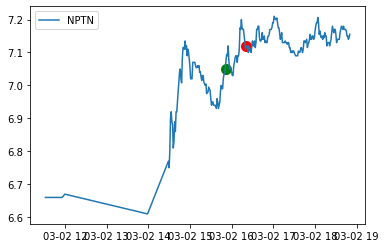

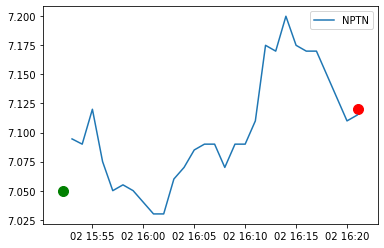

Delta = 0.07000000000000028


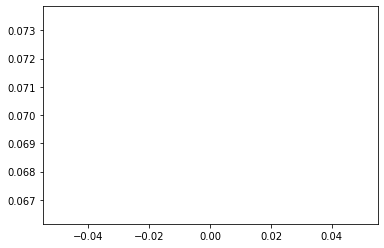

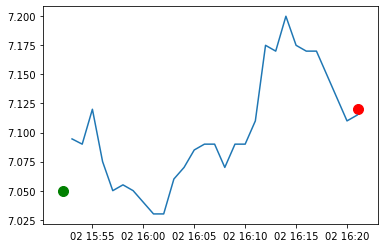

buy time:2020-03-02T15:52:05.918945186Z sell time:2020-03-02T16:21:02.525576088Z
{'rsi': 69.50424871491899, 'macd1': [-0.003542359173887455, 0.0007564724847881621, 0.005312463414123947, 0.008821431083385178, 0.013065534743537555], 'macd2': [0.0146917446623398, 0.014944594211730333, 0.015393226133482152, 0.01578136253788731, 0.016433092412491135], 'sell_macd': [-0.0015614815235887036, 0.0012339115366479803, 0.004175335849343931, 0.006413129653401128, 0.009112538725998931], 'macd_signal': [-0.012058208970042767, -0.009495272679076582, -0.006533725460436476, -0.003462694151672145, -0.00015704837263020481], 'sell_macd_signal': [-0.007399546396228468, -0.0056728548096531784, -0.0037032166778537563, -0.0016799474116027794, 0.00047854981591756267]}
{'rsi': 53.25246748222953, 'macd': [0.02352884730637239, 0.022080807743628306, 0.019626740451313296, 0.016420626451440157, 0.01422858143268968], 'scalp': 0, 'bail_out': 1, 'movement': 0.00921332388377043, 'too_close': 1, 'macd_signal': [0.019504267

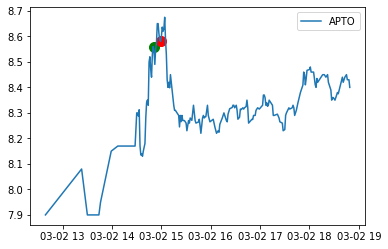

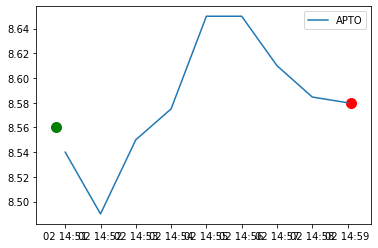

Delta = 0.019999999999999574


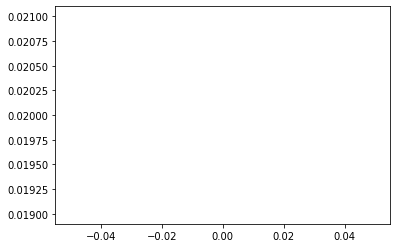

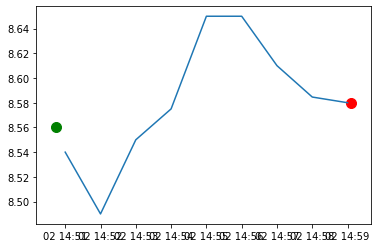

buy time:2020-03-02T14:50:44.864359777Z sell time:2020-03-02T14:59:06.121916146Z
{'rsi': 69.86018234090109, 'macd1': [0.12239339208237077, 0.1260054547211027, 0.1250062963358225, 0.12997839393896982, 0.13478583913871134], 'macd2': [0.07030826950324531, 0.07370832226692592, 0.07623878532976569, 0.079884383237113, 0.08359049409351371], 'sell_macd': [0.07474329515421374, 0.07679103777138074, 0.07583095360590875, 0.07877334317039875, 0.08160152538726884], 'macd_signal': [0.0967869189422475, 0.10263062609801854, 0.10710576014557933, 0.11168028690425744, 0.11630139735114822], 'sell_macd_signal': [0.05900380440444617, 0.06256125107783309, 0.06521519158344821, 0.06792682190083832, 0.07066176259812443]}
{'rsi': 64.21674381143075, 'macd': [0.07991032167769418, 0.08098101657871482, 0.07868570070186465, 0.07455577013935866, 0.070649905153779], 'scalp': 0, 'bail_out': 1, 'movement': 0.0035046728971961866, 'too_close': 1, 'macd_signal': [0.0760961003796004, 0.07707308361942329, 0.07739560703591156, 

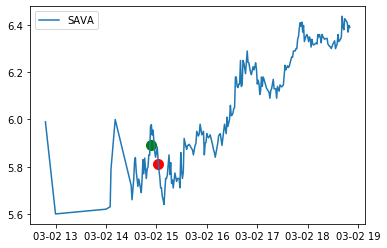

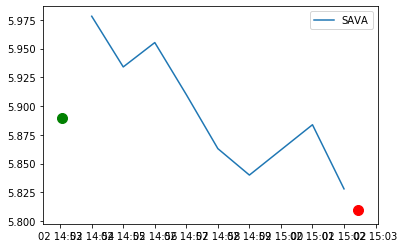

Delta = -0.08000000000000007


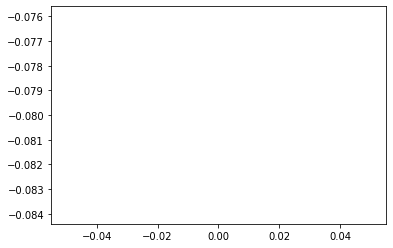

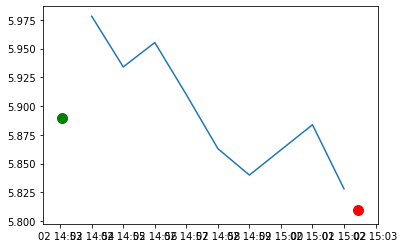

buy time:2020-03-02T14:53:04.060311385Z sell time:2020-03-02T15:02:26.303331334Z
{'rsi': 58.19629310008834, 'macd1': [0.03401138414382565, 0.0342367152884977, 0.03816326572619122, 0.04080471389559648, 0.04560009677594934], 'macd2': [0.025490504551912707, 0.02616692477249849, 0.02757747064554028, 0.02883111165765051, 0.030578134257503997], 'sell_macd': [0.020003549636166795, 0.020102652020549172, 0.0226149051509692, 0.024278804925959463, 0.027337963128212017], 'macd_signal': [0.033845094825538366, 0.033923418918130235, 0.03477138827974243, 0.03597805340291324, 0.03790246207752046], 'sell_macd_signal': [0.020177754559983444, 0.02016273405209659, 0.020653168271871112, 0.021378295602688783, 0.02257022910779343]}
{'rsi': 48.422563984661146, 'macd': [0.03918425754560673, 0.03511910185959621, 0.030300550651540803, 0.028427646454984412, 0.022765284140070285], 'scalp': 0, 'bail_out': 0, 'movement': -0.013582342954159604, 'too_close': 1, 'macd_signal': [0.03268331731171334, 0.033170474221289915,

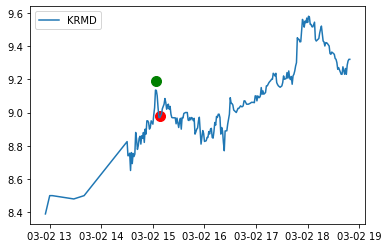

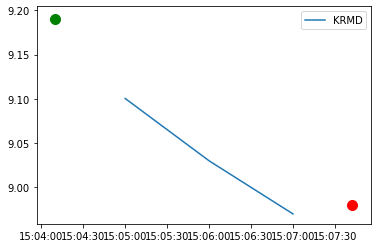

Delta = -0.20999999999999908


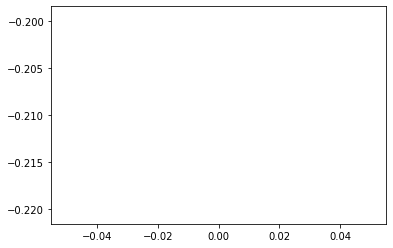

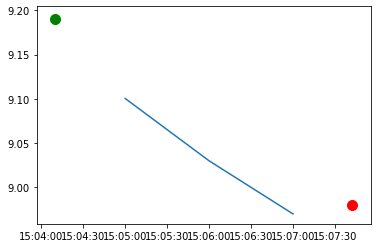

buy time:2020-03-02T15:04:09.47910319Z sell time:2020-03-02T15:07:42.337654721Z
{'rsi': 72.9618742049256, 'macd1': [0.10019560943766948, 0.09919785927607805, 0.10076374892980411, 0.10929014396984904, 0.11911236066538322], 'macd2': [0.10185928261233101, 0.10310041731053055, 0.1047747272950641, 0.10784129601366921, 0.1113698083837047], 'sell_macd': [0.05486090353684858, 0.05433257878756592, 0.05548021432335126, 0.06115525221716567, 0.06764027846926624], 'macd_signal': [0.11813661261407307, 0.11434886194647406, 0.11163183934314007, 0.11116350026848186, 0.11275327234786213], 'sell_macd_signal': [0.06662686013723833, 0.06416800386730384, 0.062430445958513325, 0.0621754072102438, 0.06326838146204829]}
{'rsi': 57.01431936097372, 'macd': [0.06115525221716567, 0.06468962911861631, 0.0648996678844398, 0.06056333876840014, 0.054839402590078024], 'scalp': 0, 'bail_out': 0, 'movement': -0.02067464635473335, 'too_close': 1, 'macd_signal': [0.0621754072102438, 0.0626782515919183, 0.0631225348504226, 

In [73]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
        if symbol not in high_15m:
            print(f'{symbol} not in high_15m, skipping...')
            continue
            
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            if trade[1] < high_15m[symbol]:
                continue
            
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue
                
                
            print(f'buy-price {trade[1]} sell-price {trade[3]}')

            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
            if trade[1] < high_15m[symbol]:
                continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
            if trade[1] < high_15m[symbol]:
                continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

